In [3]:
# load packages
%matplotlib notebook
import os
import astropy.io.fits as fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np
import scipy.ndimage.filters as filters
import scipy.interpolate as interpol
from astropy.coordinates import SkyCoord, Galactic
import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [4]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import skimage.filters
def detect_ridges(gray, sigma=3.0):
    hxx, hyy, hxy = hessian_matrix(gray, sigma, order="rc")
    i1, i2 = hessian_matrix_eigvals([hxx, hxy, hyy])
    return i1, i2

In [ ]:
s = 10
u,v = skimage.filters.sobel_h(z), skimage.filters.sobel_v(z)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=wcs_12CO[650:1130:s,850:1600:s])
ax.imshow(z[::s,::s], origin='lower')
ax.quiver(v[::s,::s], u[::s,::s], units='xy', scale=1, color='white')

# Generate mock filaments

In [5]:
def V(x, y):
    p = np.sin(np.sin(y)*x + np.sin(x)*y)
    return np.sin(p) * np.exp(p*np.cos(p))

def W(x, y, xcen=0, ycen=0, xampli=1, yampli=1, xfreq=1, yfreq=1,
      xwidth=0.5, ywidth=0.5, peak=1.0):
    # xcen, ycen
    # orientation
    # length
    # width
    # nsinu
    x0 = xcen + xampli*np.sin(y*xfreq)
    y0 = ycen + yampli*np.sin(x*yfreq)
    k = -0.5 * (((x-x0)/xwidth)**2 + ((y-y0)/ywidth)**2)
    return peak * np.exp(k)


def multiW(x, y, pdicts):
    z = np.zeros_like(x)
    for p in pdicts:
        z = z + W(x, y, **p)
    return z

<IPython.core.display.Javascript object>


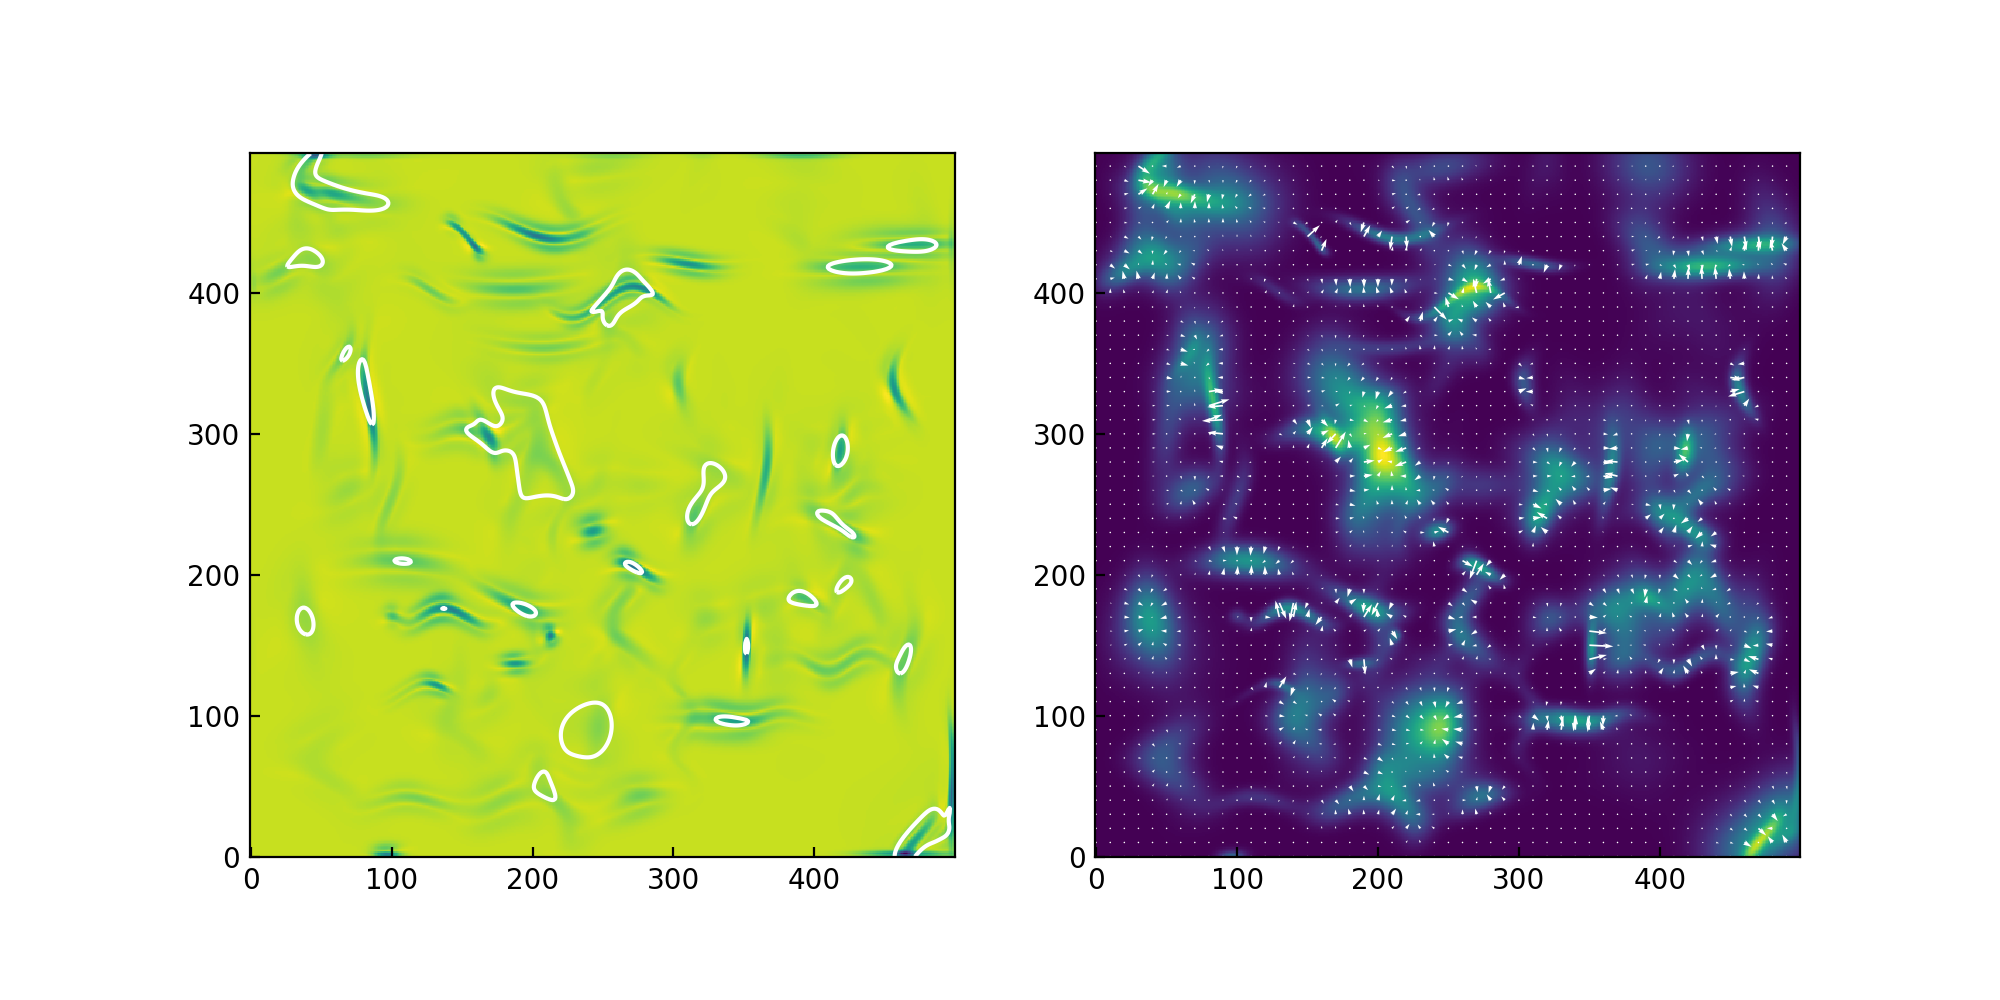

In [57]:
min_, max_ = -10.0, 10.0
_ = np.linspace(min_, max_, num=500)
x,y = np.meshgrid(_, _)
#v = V(x,y)

n = 100
xcen = np.random.uniform(low=min_, high=max_, size=n)
ycen = np.random.uniform(low=min_, high=max_, size=n)
xampli = np.random.uniform(low=0.1, high=0.5, size=n)
yampli = np.random.uniform(low=0.1, high=0.5, size=n)
xfreq = np.random.uniform(low=0.1, high=3, size=n)
yfreq = np.random.uniform(low=0.1, high=3, size=n)
xwidth = np.random.uniform(low=0.1, high=1, size=n)
ywidth = np.random.uniform(low=0.1, high=1, size=n)
peak = np.random.uniform(low=0.1, high=1, size=n)
pdicts = [{'xcen': xcen[i],
           'ycen': ycen[i],
           'xampli': xampli[i],
           'yampli': yampli[i],
           'xfreq': xfreq[i],
           'yfreq': yfreq[i],
           'xwidth': xwidth[i],
           'ywidth': ywidth[i],
           'peak': peak[i]
          } for i in range(n)]
z = multiW(x, y, pdicts)

u, v = skimage.filters.sobel_h(z), skimage.filters.sobel_v(z)

s = 10
e1,e2 = detect_ridges(z, sigma=2.0)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(e2, origin='lower')
ax.contour(z, levels=np.array([0.5])*z.max(), colors='white')
x_, y_ = np.arange(0, z.shape[0], s), np.arange(0, z.shape[0], s)

ax = fig.add_subplot(1,2,2)
ax.imshow(z, origin='lower')
ax.quiver(x_, y_, v[::s,::s], u[::s,::s], units='xy', scale=0.02, color='white')

<IPython.core.display.Javascript object>


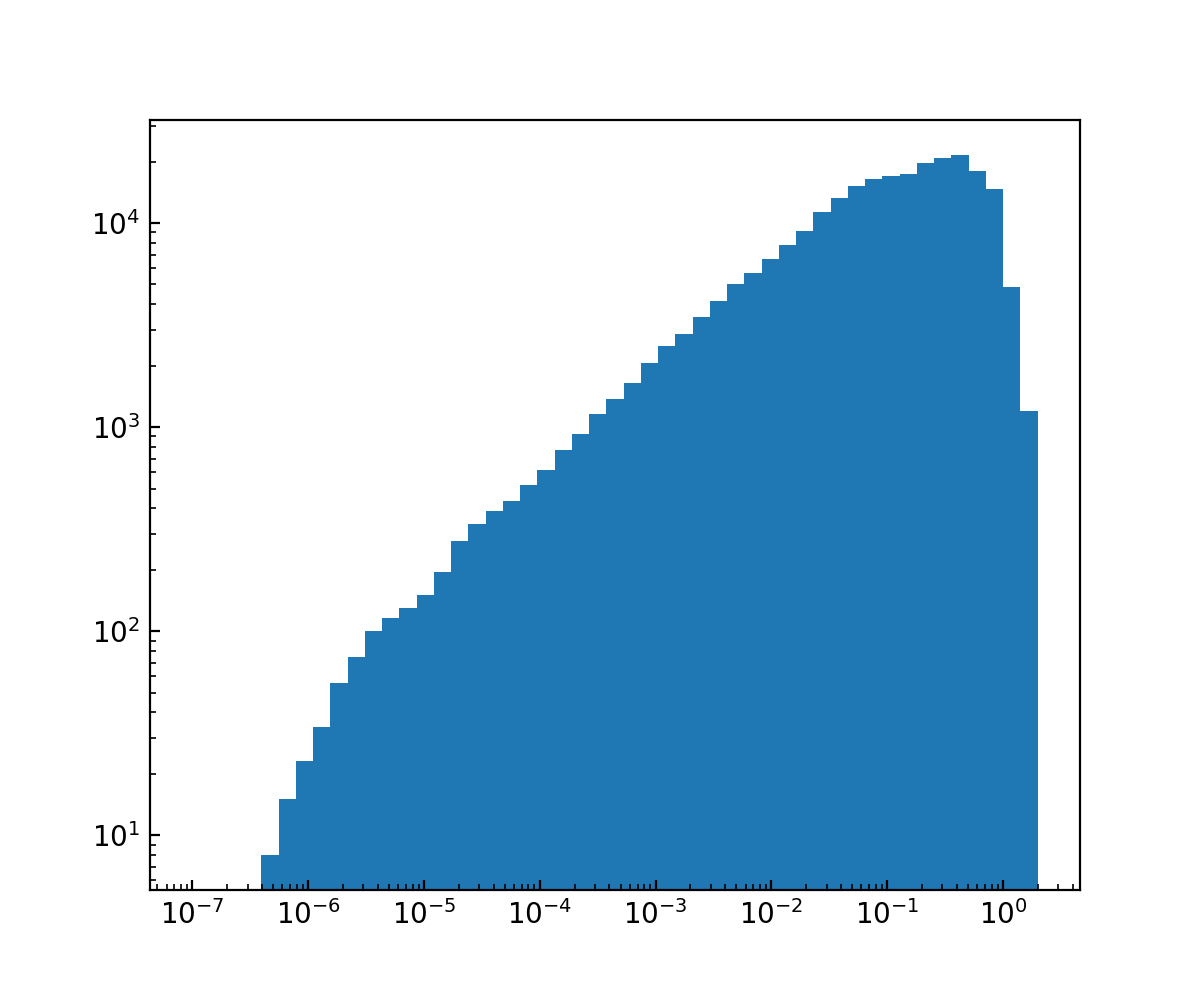

In [76]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1)
ax.set_xscale('log')
ax.set_yscale('log')
_ = ax.hist(z.flatten(), bins=np.logspace(-7,0.3))

<IPython.core.display.Javascript object>


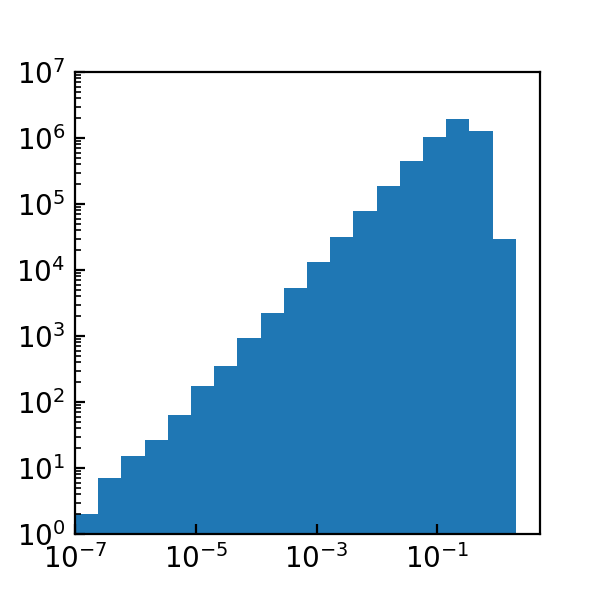

In [114]:
z = np.random.normal(loc=0, scale=0.3, size=10000000)
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e-7,5))
ax.set_ylim((1e0,1e7))
_ = ax.hist(z.flatten(), bins=np.logspace(-7,0.3, num=20))

# Play with Newton iteration

This is related with the issue of mapping mesh points to a surface

In [ ]:
def f(x,y):
    return np.sin(x) - y

def df(x,y):
    return (np.cos(x), -np.ones_like(y))

def newton(g, dg, x, y):
    dg_ = dg(x, y)
    dgm = dg_[0]**2 + dg_[1]**2
    return (x - g(x, y) * dg_[0] /  dgm,
            y - g(x, y) * dg_[1] / dgm)

<IPython.core.display.Javascript object>


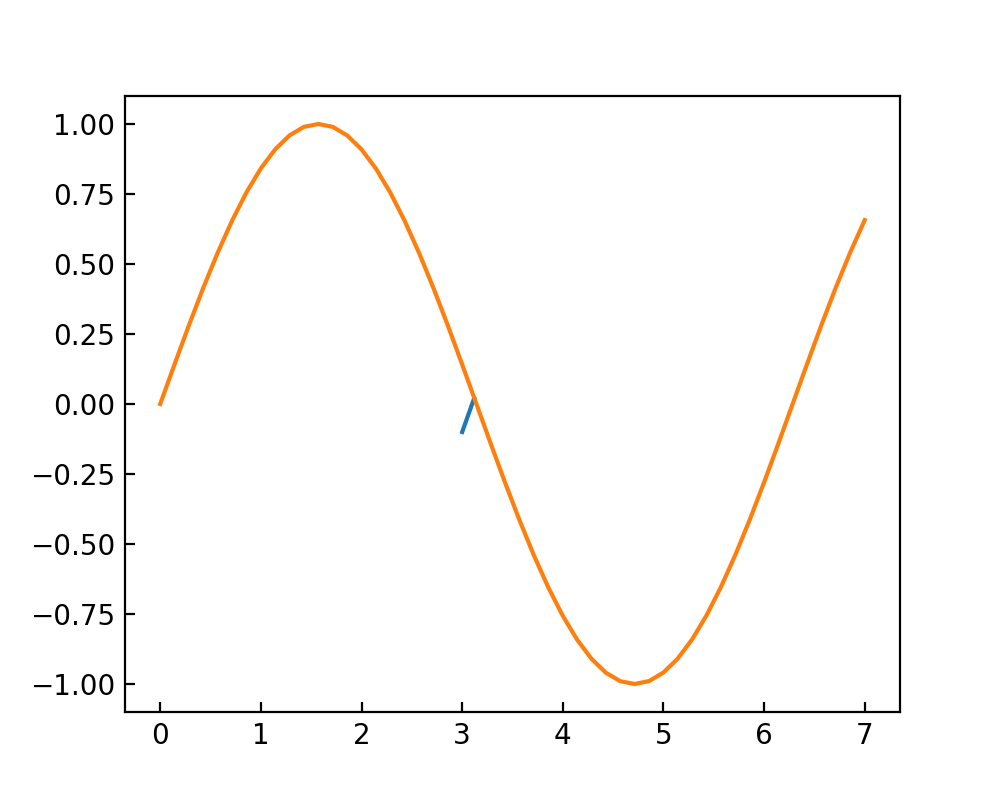

In [6]:
x0 = (3,-0.1)
xy = [x0]
for i in range(10):
    x0 = newton(f, df, *x0)
    xy.append(x0)
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
x,y = zip(*xy)
ax.plot(x, y)
x = np.linspace(0,7)
ax.plot(x, np.sin(x))
#ax.set_xlim((2.4, 2.8))

# Play with FRB

In [7]:
import csv
with open('/Users/fjdu/download/frbcat_20190110.csv', 'r') as f:
    rd = csv.reader(f)
    rows = [r for r in rd]

In [8]:
rmp_dm = [float(r[-3].split('&')[0]) for r in rows[1:]]

<IPython.core.display.Javascript object>


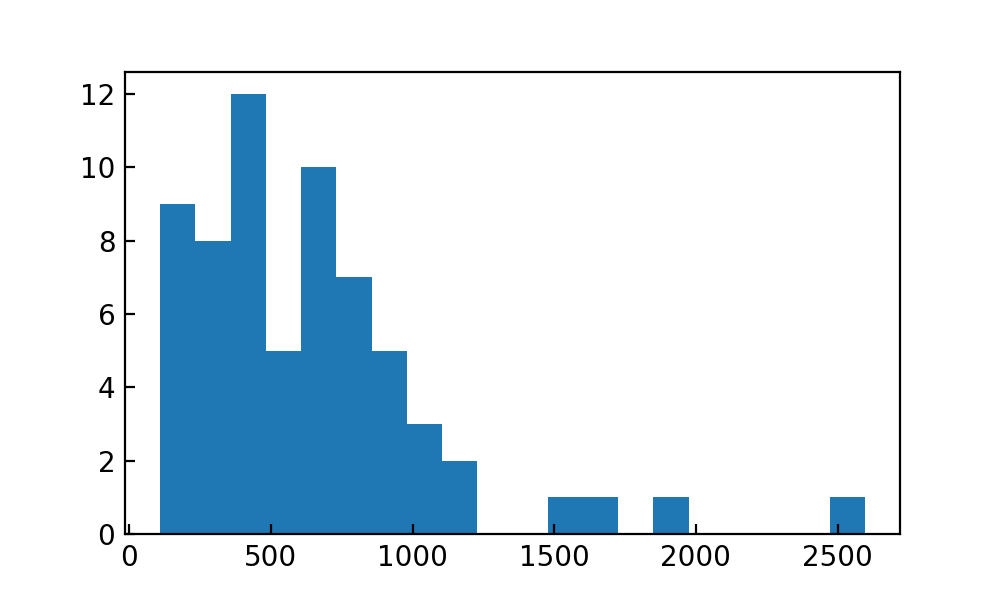

(array([ 9.,  8., 12.,  5., 10.,  7.,  5.,  3.,  2.,  0.,  0.,  1.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 109.61  ,  233.9345,  358.259 ,  482.5835,  606.908 ,  731.2325,
         855.557 ,  979.8815, 1104.206 , 1228.5305, 1352.855 , 1477.1795,
        1601.504 , 1725.8285, 1850.153 , 1974.4775, 2098.802 , 2223.1265,
        2347.451 , 2471.7755, 2596.1   ]),
 <a list of 20 Patch objects>)

In [9]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)
ax.hist(rmp_dm, bins=20)